In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = ""
assert not cira.auth.check_keys()

SYMBOL = "ETH/USD" 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Cryptocurrency(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2021, 1, 1)
    end = datetime.now().date() 
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,ETH/USD,742.15,745.00,716.65,733.65,6534.81013,6514.0,731.807780
2021-01-02 06:00:00+00:00,ETH/USD,735.29,791.08,725.44,786.88,16071.74933,15214.0,769.787732
2021-01-03 06:00:00+00:00,ETH/USD,786.64,1098.00,784.55,1086.86,44039.92386,43031.0,942.620484
2021-01-04 06:00:00+00:00,ETH/USD,1086.86,1169.05,880.00,991.40,50778.44556,51353.0,1030.893782
2021-01-05 06:00:00+00:00,ETH/USD,992.00,1138.00,980.08,1105.56,25283.79028,26369.0,1073.661942


<Axes: xlabel='timestamp'>

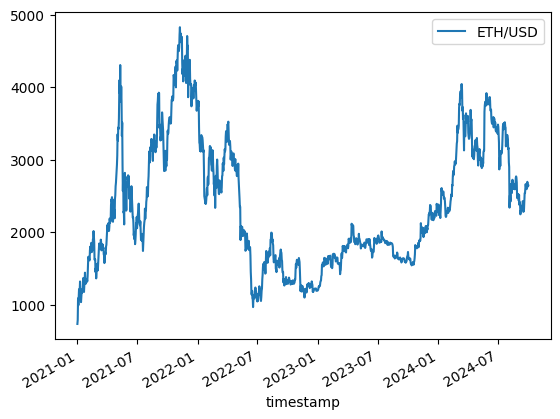

In [2]:
data.plot.line(y="close", use_index=True, label=SYMBOL)

In [3]:
from numpy import ndarray
from pandas import DataFrame

class Optimal(cira.strategy.Strategy):
    def __init__(self) -> None:
        super().__init__(name="Optimal")
        self.sell_at_idx = 0 
        self.buy_at_idx = 0 

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray:
        assert self.buy_at_idx <= self.sell_at_idx, "max is before min in value "
        action = [0]
        if len(prices) - 1 == self.buy_at_idx: 
            action = (cash//prices.values[-1]).tolist()
        if len(prices) - 1 == self.sell_at_idx: 
            action = [(-portfolio[-1]).tolist()]
        return np.array(action)

    def fit(self, prices: DataFrame, col_name:str):
        self.buy_at_idx = int(prices[col_name].argmin())
        self.sell_at_idx = int(prices[col_name].iloc[self.buy_at_idx:].argmax())

In [4]:
strat = Optimal()
strat.fit(data["close"].to_frame(), "close")
strat.buy_at_idx, strat.sell_at_idx

(0, 311)

<Axes: xlabel='timestamp'>

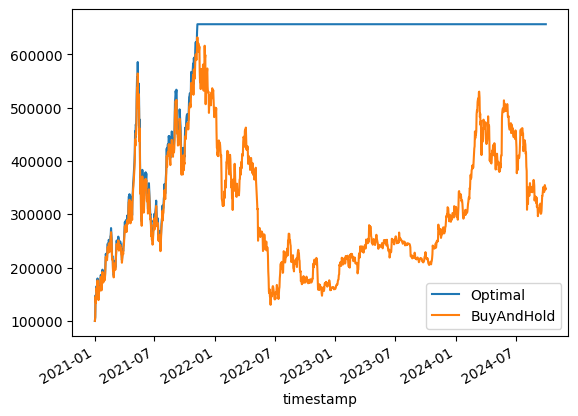

In [5]:

from cira.strategy import back_test_against_buy_and_hold, back_test
back_test_against_buy_and_hold(strat, data, data["close"].to_frame(), 100_000, use_fees=False).plot()

<Axes: xlabel='timestamp'>

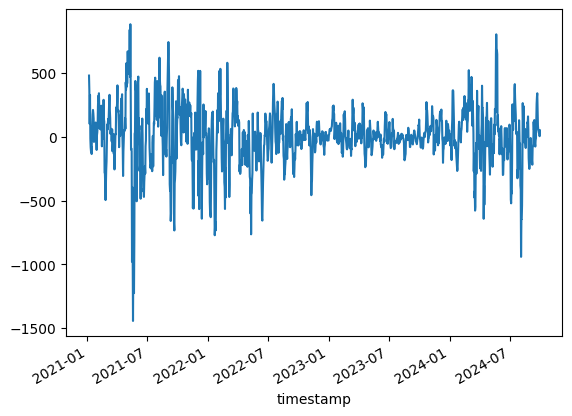

In [7]:

data["close"].diff(5).plot()

In [ ]:
def create_buy_signal(df, threshold=0.05, forward_days=5):
    future_price = df['price'].shift(-forward_days)
    price_change = (future_price - df['price']) / df['price']
    return (price_change > threshold).astype(int)

df = data.copy() 
df['buy_signal'] = create_buy_signal(df)

df['MA5'] = df['price'].rolling(window=5).mean()
df['MA20'] = df['price'].rolling(window=20).mean()
df['MA50'] = df['price'].rolling(window=50).mean()

df['momentum'] = df['price'].pct_change(periods=5)

df['volatility'] = df['price'].rolling(window=20).std()

df_clean = df.dropna()

X = df_clean[['MA5', 'MA20', 'MA50', 'momentum', 'volatility']]
y = df_clean['buy_signal']